# Validating fine-tuned Generator via fine-tuned Classifier

In [1]:
# setup 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset
import re
import nltk
from nltk.tokenize import sent_tokenize


# load data
generated_speeches_df = pd.read_csv("../data/generated_speeches_final_context_v2.csv")
GPT_data = pd.read_csv("../data/gpt_speeches/gpt_speeches.csv", sep = ";")
# rename label CDU/CSU correctly for mapping later
generated_speeches_df["party"] = generated_speeches_df["party"].replace({
    "Union": "CDU/CSU"
})
GPT_data["party"] = GPT_data["party"].replace({
    "Union": "CDU/CSU"
})

______________________________________________________________
Minor Preprocessing of all generated speeches
______________________________________________________________

In [2]:
# preprocess GPT speeches separately
GPT_data = GPT_data.dropna(subset=["speech_text"])
GPT_data = GPT_data.rename(columns={"party": "label"})
GPT_data = GPT_data[["speech_text", "label"]]
GPT_data = Dataset.from_pandas(GPT_data, preserve_index=False)

In [50]:
GPT_data

Dataset({
    features: ['speech_text', 'label'],
    num_rows: 21
})

In [3]:
# seperate dfs per model answers
all_columns_to_predict = ['speech_base_model_01', 
                          'speech_ft_model_01',
                          'speech_base_model_03', 
                          'speech_ft_model_03', 
                          'RAG_speech_01',
                          'RAG_speech_03']


data_dict = {}

for column in all_columns_to_predict:
    df = generated_speeches_df[["party", column]].rename(columns={"party": "label", column: "speech_text"})
    data_dict[column] = Dataset.from_pandas(df)

# save single dfs:
speech_base_model_01 = data_dict["speech_base_model_01"]
speech_ft_model_01 = data_dict["speech_ft_model_01"]
speech_base_model_03 = data_dict["speech_base_model_03"]
speech_ft_model_03 = data_dict["speech_ft_model_03"]
RAG_speech_01 = data_dict["RAG_speech_01"]
RAG_speech_03 = data_dict["RAG_speech_03"]

# add GPT speeches to dict
data_dict["GPT-4mini"] = GPT_data


In [4]:
data_dict

{'speech_base_model_01': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'speech_ft_model_01': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'speech_base_model_03': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'speech_ft_model_03': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'RAG_speech_01': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'RAG_speech_03': Dataset({
     features: ['label', 'speech_text'],
     num_rows: 24
 }),
 'GPT-4mini': Dataset({
     features: ['speech_text', 'label'],
     num_rows: 21
 })}

In [5]:
# functions to delete all party mentions
def extract_and_remove_party_mentions(speech_text, party):
    if not isinstance(speech_text, str):
        return [], speech_text

    sentences = sent_tokenize(speech_text, language='german')
    party_lower = party.lower()

    matched = [s for s in sentences if party_lower in s.lower()]
    cleaned = [s for s in sentences if party_lower not in s.lower()]

    cleaned_text = ' '.join(cleaned)
    return matched, cleaned_text


cleaned_data_dict = {}

for name, dataset in data_dict.items():
    # Convert to pandas
    df = dataset.to_pandas()

    # Apply extraction and cleaning
    matches_and_cleaned = df.apply(
        lambda row: extract_and_remove_party_mentions(row["speech_text"], row["label"]), axis=1
    )
    
    # Separate matched and cleaned
    df["matches"] = matches_and_cleaned.apply(lambda x: x[0])
    df["speech_text"] = matches_and_cleaned.apply(lambda x: x[1])
    a = df
    # Convert back to Hugging Face Dataset
    cleaned_data_dict[name] = Dataset.from_pandas(df)



In [7]:
a["speech_text"][0]

'Sehr geehrte Frau Präsidentin, liebe Kolleginnen und Kollegen,\n\nseit seiner Einführung im Jahr 2015 hat der flächendeckende gesetzliche Mindestlohn in Deutschland nicht nur Millionen von Beschäftigten ein gesichertes Einkommen über der Armutsgrenze verschafft, sondern auch gezeigt, wie wir als Gemeinschaft dafür sorgen können, dass Arbeit sich lohnt. Doch eine so wichtige Errungenschaft darf nicht in Stein gemeißelt sein; sie muss sich an die Realität unseres Arbeits- und Wirtschaftsmarkts anpassen. Wenn heute Menschen eine Vollzeitstelle antreten, sollen sie davon leben können, ohne ergänzende Leistungen des Staates in Anspruch nehmen zu müssen. Das Prinzip „Arbeit statt Sozialhilfe“ gilt ungebrochen: Der Mindestlohn muss verhindern, dass Arbeitnehmerinnen und Arbeitnehmer trotz Vollzeitarbeit am Ende des Monats aufstocken oder mehrere Jobs gleichzeitig annehmen. Gleichzeitig dürfen wir jedoch nicht übersehen, dass eine einseitig und zu hoch angesetzte Anhebung gerade kleine und mi

______________________________________________________________
Load best classifier model and define functions
______________________________________________________________

In [ ]:
# load best classifier model

# Load model and tokenizer from local folder
model = AutoModelForSequenceClassification.from_pretrained("../data/Classifier_gbert_fulltext_weighted")
tokenizer = AutoTokenizer.from_pretrained("../data/Classifier_gbert_fulltext_weighted")


In [39]:
# define parameters
WINDOW_LENGTH = 512
STRIDE = 256
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

In [40]:
# define functions to tokeize test data and predict test data with fine-tuned model
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"] 
        })

    for item in results:
      probs = item["probs"]
      pred_idx = int(np.argmax(probs))
      item["prediction_label"] = label_names[pred_idx]
    return results


In [41]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



______________________________________________________________
Classify all generated speeches
______________________________________________________________

In [42]:
# predict all generated test speeches
all_models_to_test = [speech_base_model_01, 
                        speech_ft_model_01,
                        speech_base_model_03, 
                        speech_ft_model_03, 
                        RAG_speech_01,
                        RAG_speech_03, 
                        GPT_data]

model_names = ['speech_base_model_01', 
                'speech_ft_model_01',
                'speech_base_model_03', 
                'speech_ft_model_03', 
                'RAG_speech_01',
                'RAG_speech_03',
                'GPT-4mini']


all_results = {}
i = 0
for dataset_to_predict in all_models_to_test:
    all_results[model_names[i]] = predict_proba_for_dataset(dataset_to_predict, sorted(label_names))
    i += 1



100%|██████████| 21/21 [01:03<00:00,  3.02s/it]


______________________________________________________________
Results
______________________________________________________________

Model: speech_base_model_01
  Accuracy: 0.2916666666666667
  Balanced Accuracy: 0.2916666666666667
  Precision: 0.24305555555555555
  Recall: 0.2916666666666667
  F1-score: 0.255952380952381
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.75      0.75      0.75         4
     CDU/CSU       0.33      0.25      0.29         4
         FDP       0.12      0.25      0.17         4
       GRÜNE       0.25      0.50      0.33         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.29        24
   macro avg       0.24      0.29      0.26        24
weighted avg       0.24      0.29      0.26        24



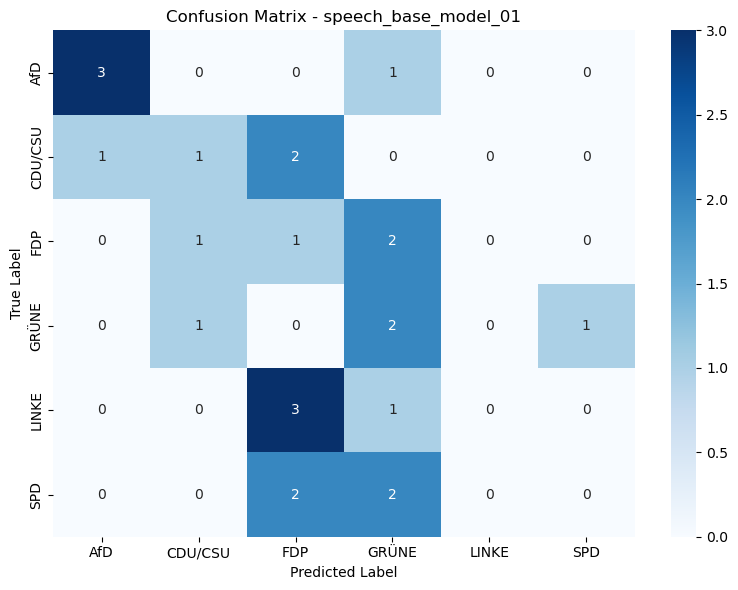

Model: speech_ft_model_01
  Accuracy: 0.25
  Balanced Accuracy: 0.25
  Precision: 0.32323232323232326
  Recall: 0.25
  F1-score: 0.2222222222222222
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.27      0.75      0.40         4
     CDU/CSU       1.00      0.25      0.40         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.00      0.00      0.00         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.17      0.25      0.20         4

    accuracy                           0.25        24
   macro avg       0.32      0.25      0.22        24
weighted avg       0.32      0.25      0.22        24



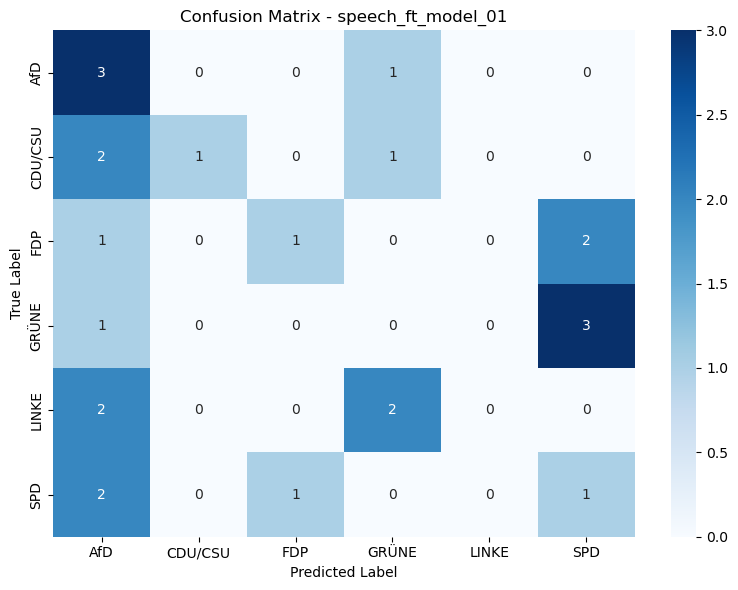

Model: speech_base_model_03
  Accuracy: 0.25
  Balanced Accuracy: 0.25
  Precision: 0.23809523809523805
  Recall: 0.25
  F1-score: 0.23376623376623376
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.33      0.25      0.29         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.29      0.50      0.36         4
       GRÜNE       0.14      0.25      0.18         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.67      0.50      0.57         4

    accuracy                           0.25        24
   macro avg       0.24      0.25      0.23        24
weighted avg       0.24      0.25      0.23        24



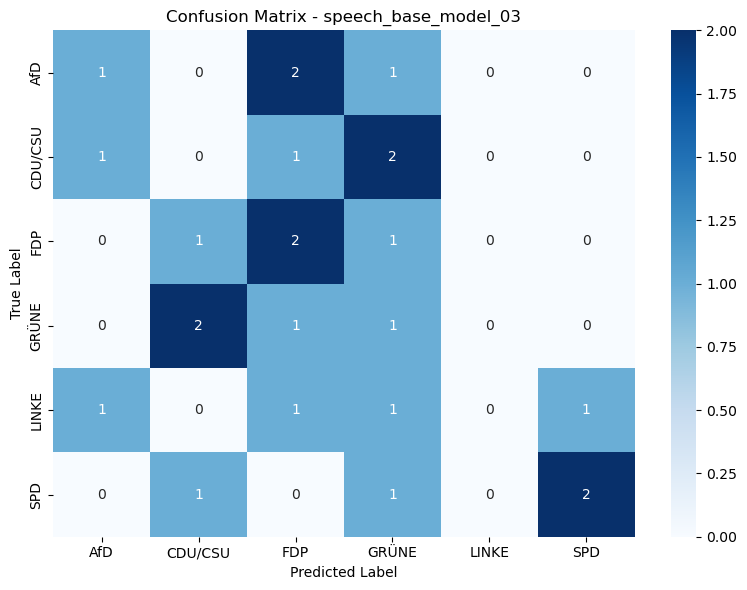

Model: speech_ft_model_03
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.12045454545454544
  Recall: 0.20833333333333334
  F1-score: 0.14537037037037034
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.27      0.75      0.40         4
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.25      0.25      0.25         4
       GRÜNE       0.00      0.00      0.00         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.20      0.25      0.22         4

    accuracy                           0.21        24
   macro avg       0.12      0.21      0.15        24
weighted avg       0.12      0.21      0.15        24



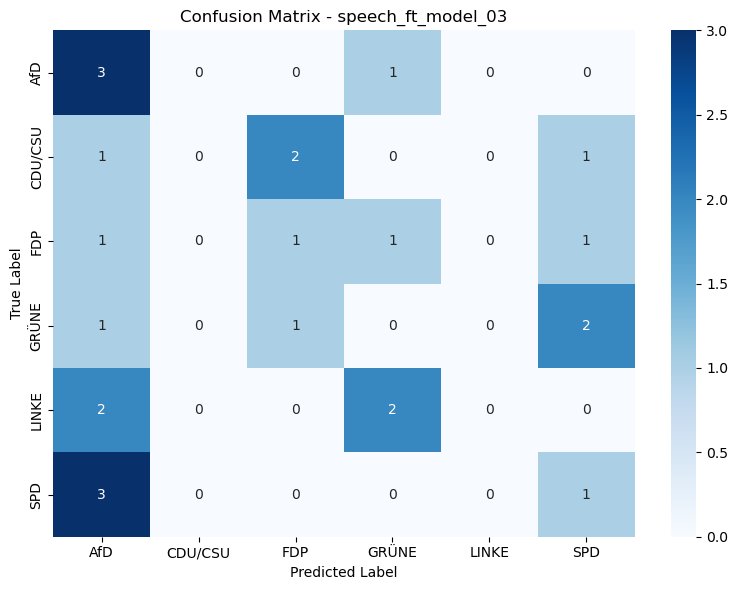

Model: RAG_speech_01
  Accuracy: 0.375
  Balanced Accuracy: 0.375
  Precision: 0.44949494949494956
  Recall: 0.375
  F1-score: 0.3333333333333333
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.36      1.00      0.53         4
     CDU/CSU       1.00      0.25      0.40         4
         FDP       1.00      0.50      0.67         4
       GRÜNE       0.00      0.00      0.00         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.33      0.50      0.40         4

    accuracy                           0.38        24
   macro avg       0.45      0.38      0.33        24
weighted avg       0.45      0.38      0.33        24



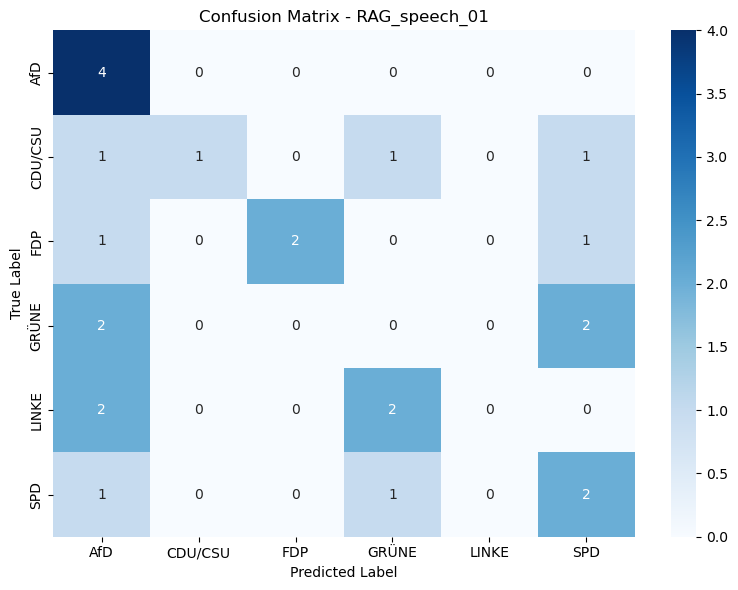

Model: RAG_speech_03
  Accuracy: 0.20833333333333334
  Balanced Accuracy: 0.20833333333333334
  Precision: 0.2222222222222222
  Recall: 0.20833333333333334
  F1-score: 0.19246031746031747
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.17      0.50      0.25         4
     CDU/CSU       0.33      0.25      0.29         4
         FDP       0.50      0.25      0.33         4
       GRÜNE       0.33      0.25      0.29         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.22      0.21      0.19        24
weighted avg       0.22      0.21      0.19        24



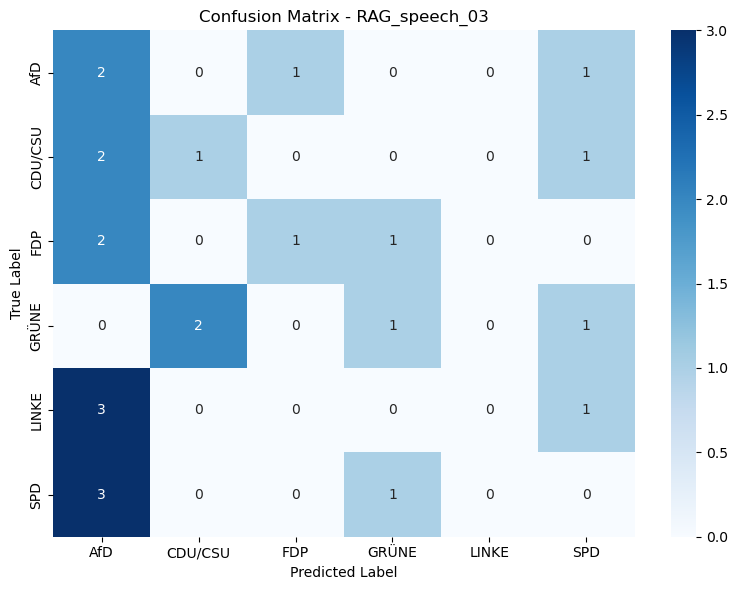

Model: GPT-4mini
  Accuracy: 0.14285714285714285
  Balanced Accuracy: 0.125
  Precision: 0.038461538461538464
  Recall: 0.125
  F1-score: 0.0588235294117647
  Classification Report:
              precision    recall  f1-score   support

         AFD       0.00      0.00      0.00         1
     CDU/CSU       0.00      0.00      0.00         4
         FDP       0.00      0.00      0.00         4
       GRÜNE       0.00      0.00      0.00         4
       LINKE       0.00      0.00      0.00         4
         SPD       0.23      0.75      0.35         4

    accuracy                           0.14        21
   macro avg       0.04      0.12      0.06        21
weighted avg       0.04      0.14      0.07        21



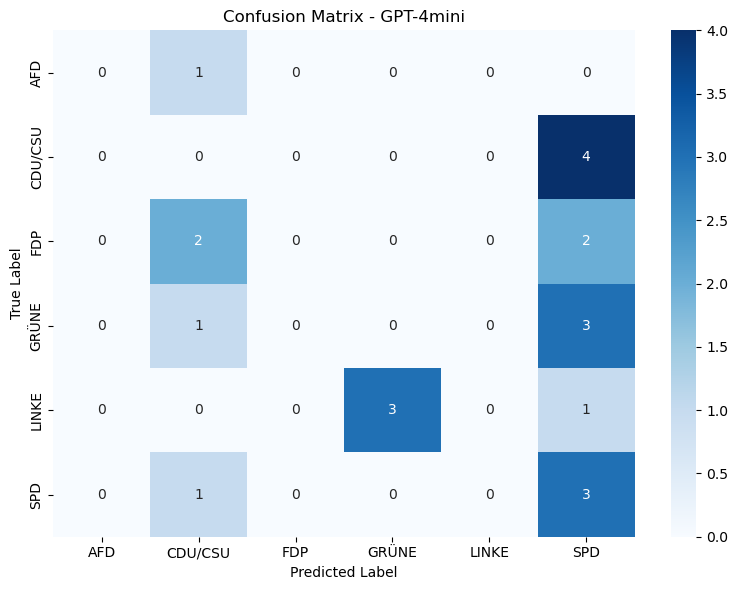

In [43]:
# run get_metrics function on all and save results 
final_performance_results = {}
i = 0

for i in range(len(model_names)):
    df = pd.DataFrame(all_results[model_names[i]])
    results =  get_metrics(df["label"], df["prediction_label"], model_names[i])
    final_performance_results.update(results)
    i += 1


In [44]:
# compare final results
final_performance_results_df = pd.DataFrame(final_performance_results)
final_performance_results_df

,speech_base_model_01,speech_ft_model_01,speech_base_model_03,speech_ft_model_03,RAG_speech_01,RAG_speech_03,GPT-4mini
acc,0.291667,0.250000,0.250000,0.208333,0.375000,0.208333,0.142857
bal_acc,0.291667,0.250000,0.250000,0.208333,0.375000,0.208333,0.125000
precision,0.243056,0.323232,0.238095,0.120455,0.449495,0.222222,0.038462
recall,0.291667,0.250000,0.250000,0.208333,0.375000,0.208333,0.125000
f1,0.255952,0.222222,0.233766,0.145370,0.333333,0.192460,0.058824


In [45]:
# Visualising the results
def visualising_results(metrics_summary, results_dict = model_names):
    """Producing comprehensive visualisation that works with any number of models"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    model_names = results_dict
    num_models = len(model_names)

    accuracies = [metrics_summary[name]['acc'] for name in model_names]
    balanced_accuracies = [metrics_summary[name]['bal_acc'] for name in model_names]
    precisions = [metrics_summary[name]['precision'] for name in model_names]
    recalls = [metrics_summary[name]['recall'] for name in model_names]
    f1_scores = [metrics_summary[name]['f1'] for name in model_names]

    # Subplot 1: Accuracy
    axes[0, 0].bar(np.arange(num_models) - 0.2, accuracies, width=0.4, label='Accuracy', color='skyblue')
    axes[0, 0].bar(np.arange(num_models) + 0.2, balanced_accuracies, width=0.4, label='Balanced Accuracy', color='lightgreen')
    axes[0, 0].set_title('Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(np.arange(num_models))
    axes[0, 0].set_xticklabels(model_names, rotation=45)
    axes[0, 0].legend()

    # Subplot 2: Precision and Recall
    width = 0.35
    x = np.arange(num_models)
    axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
    axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
    axes[0, 1].set_title('Precision and Recall')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(model_names, rotation=45)
    axes[0, 1].legend()

    # Subplot 3: F1
    axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Subplot 4: Overall Performance Comparison
    metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
    for idx, name in enumerate(model_names):
        model_scores = [
            accuracies[idx],
            balanced_accuracies[idx],
            precisions[idx],
            recalls[idx],
            f1_scores[idx],
        ]
        marker = ['o', 's', '^', 'D', 'x'][idx % 5]  # Use different markers
        axes[1, 1].plot(metrics, model_scores, marker + '-', label=name, linewidth=2, markersize=8)

    axes[1, 1].set_title('Overall Performance Comparison')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


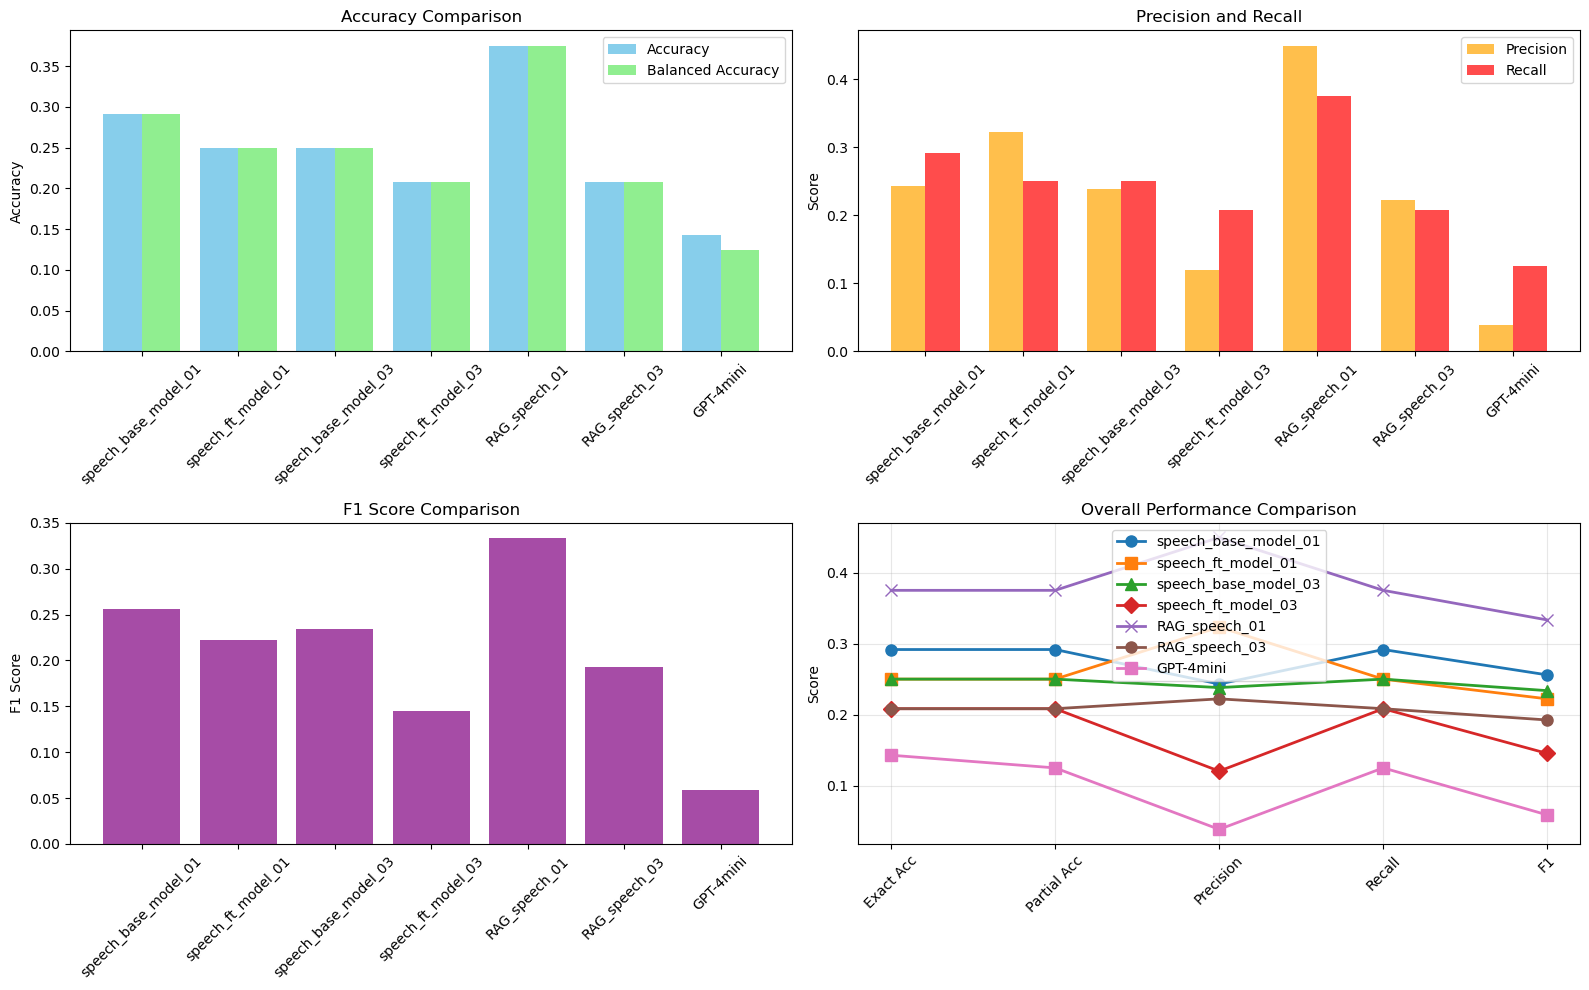

In [46]:
visualising_results(final_performance_results, results_dict = model_names)